In [39]:
import numpy as np
import pandas as pd

ar = np.genfromtxt('../data/A/combined_traces/10uM_idl.csv', delimiter=',')

In [2]:
from sfkinetics import PopData

popdata = PopData(ar)

In [266]:
d = dict(A = 0.437, k=1.057, t0=4.874, b=-0.005, c=0.508)
s = pd.Series(d)
print(str(s).rstrip("ndtype: float64"))

A     0.437
k     1.057
t0    4.874
b    -0.005
c     0.508



In [284]:
from scipy.optimize import curve_fit
from plotnine import ggplot, geom_line, aes, xlab, ylab, coord_cartesian, geom_point, geom_label, annotate
import textwrap

#class FitParams():
#    def __init__(self):


# Define the custom fitting function combining exponential decay and linear change
def fit_func(x, A, k, x0, b, c):
    return A*np.exp(-k*(x - x0)) + b*x + c

class TransitionFitting:
    def __init__(self, popdata, t1=5, t2=25, t3=40):
        self.data = popdata.data
        self.t1 = t1
        self.t2 = t2
        self.t3 = t3
        self._fit1()
        self._fit2()
    
    def _fit1(self):
        """Fit first transition"""
        df = self.data.query(f"{self.t1} <= time and time <= {self.t2}")
        x, y = df.time, df.state_occupancy
        
        # Initial guess for the parameters: [A, B, C, D]
        initial_guess = [0.5, 1, self.t1, 0, 0.5]
        
        # Boundaries for the parameters (e.g., A > 0, B > 0, etc.)
        param_bounds = ([0, 0, self.t1 - 1, -1, 0], [1, np.inf, self.t1 + 1, 1, 1])
        
        # Fit the data to the custom decay function
        self.params1, self.covariance = curve_fit(fit_func, x, y, p0=initial_guess, bounds=param_bounds)
    
    def _fit2(self):
        """Fit second transition"""
        df = self.data.query(f"{self.t2} <= time and time <= {self.t3}")
        x, y = df.time, df.state_occupancy
        
        # Initial guess for the parameters: [A, B, C, D]
        initial_guess = [-0.5, 1, self.t2, 0.1, 0.5]
        
        # Boundaries for the parameters (e.g., A > 0, B > 0, etc.)
        param_bounds = ([-1, 0, self.t2 - 1, -1, 0], [0, np.inf, self.t2 + 1, 1, 1])
        
        # Fit the data to the custom decay function
        self.params2, self.covariance = curve_fit(fit_func, x, y, p0=initial_guess, bounds=param_bounds)
        
    def _print_fit_params(self, params):
        return textwrap.dedent(f"""
            A = {params[0]:.3f}
            k = {params[1]:.3f}
            t = {params[2]:.3f}  
            C = {params[3]:.3f}
            D = {params[4]:.3f}""").strip()
        
    def __repr__(self):
        return ("Fitting result for FRET transition rates\n"
                + self._print_fit_params(self.params1)
                + "\n\n"
                + self._print_fit_params(self.params2)
                )
    
    def _gg_data_layer(self):
        return [geom_point(aes(x='time', y='state_occupancy'), data=self.data)]
    
    def _gg_fit1_layer(self):
        x = np.linspace(self.params1[2], self.params2[2], 100)
        y = fit_func(x, *self.params1)
        fit_lbl = self._print_fit_params(self.params1)
        
        return [
            geom_line(aes(x=x, y=y), color='red'),
            geom_label(aes(x = self.t1 + 5, y = tf.params1[[0,4]].sum()), label = fit_lbl, ha='left', va='top'),
                ]
    
    def _gg_fit2_layer(self):
        df = self.data.from_to(self.t2, self.t3)
        df.state_occupancy = fit_func(df.time, *self.params2)
        fit_lbl = self._print_fit_params(self.params2)
        
        return [
            geom_line(aes(x='time', y='state_occupancy'), data=df, color='red'),
            geom_label(aes(x = self.t2 + 5, y = tf.params1[4]), label = fit_lbl, ha='left', va='bottom',),
                ]
    
    def gglayer(self):
        return [
            *self._gg_data_layer(),
            *self._gg_fit1_layer(),
            *self._gg_fit2_layer(),
            xlab("Time, s"),
            ylab("State occupancy"),
        ]

    def ggplot(self):
        plot = ggplot()
        for layer in self.gglayer():
            plot += layer
        return plot + coord_cartesian(xlim=(0, self.t3))

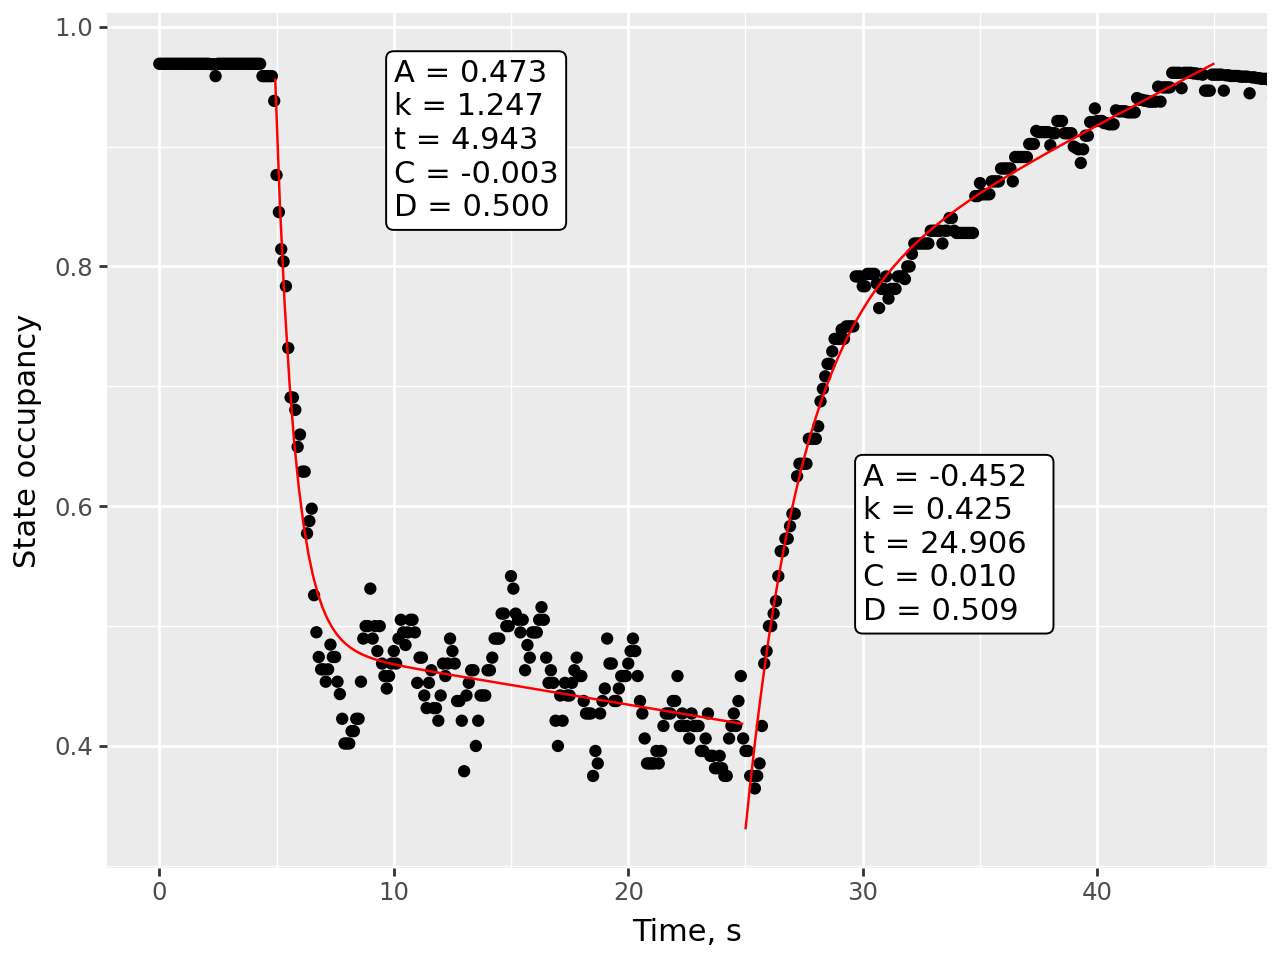

In [285]:
popdata = PopData(ar[np.random.choice(ar.shape[0], 100, replace=True)])
tf = TransitionFitting(popdata, t1=5, t2=25, t3=45)
tf.ggplot()